# DDE model with gradients

DDEs require models that produces output beased on its gradients wrt. to the input. So we make our own model that transfers the output of a neural network by computing its gradients.

In [1]:
from tensorflow import keras

class DDE(keras.Model):
    def __init__(self, net_model):
        super(DDE, self).__init__()
        self.net_model = net_model

    def compile(self, optimizer):
        super(DDE, self).compile()
        self.optimizer = optimizer

    # Replace the call function of the model to include the gradient computation
    def call(self, noisy_input):

        # 1. Get the discriminator output for this interpolated image.
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(noisy_input)
            log_prob = self.net_model(noisy_input, training=True)

        # 2. Calculate the gradients w.r.t to the input.
        grad_log_prob = gp_tape.gradient(log_prob, [noisy_input])[0]
                
        return log_prob, grad_log_prob

    # Calculate the noise estimation penalty based on MSE (Eq. 5 in paper)
    def noise_estimation_penalty(self, noisy_input, gt):
        """ Calculates the denoising penalty.
        """
        _, noise_estim = self.call(noisy_input) # compute the noise as the gradients of the network
        
        # 3. Calcuate the loss
        loss = tf.keras.losses.mean_squared_error(noise_estim, gt)
        
        return loss

    # Calculate model gradients for optimization and take an optimizatino step.
    # TF will implicitly include the loss gradients by going through the noise-estimation branch.
    def train_step(self, input):
        noisy_input = input[0]
        gt = input[1]

        # Get the batch size
        batch_size = tf.shape(noisy_input)[0]

        with tf.GradientTape() as tape:
            loss = self.noise_estimation_penalty(noisy_input, gt)

        # Get the gradients w.r.t the generator loss
        gradient = tape.gradient(loss, self.net_model.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.optimizer.apply_gradients(
            zip(gradient, self.net_model.trainable_variables)
        )
        return {"loss": loss}


In [2]:
# Generate neral network model for DDE. We need to satisfy two cnoditions:
# 1. The output of the network is a scalar value: we apply this by setting the number of neurons in the last layer to 1
# 2. The network is twice-differentiable: we achive this by using TanH activations

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import tensorflow as tf

kernel_initializer = 'he_normal'

def generate_net_model(pretrained_weights = None, input_size=(2), ch=32):
    inputs = Input(input_size)
    layer1 = Dense(ch, activation='tanh', kernel_initializer=kernel_initializer)(inputs)
    layer2 = Dense(ch, activation='tanh', kernel_initializer=kernel_initializer)(layer1)
    layer3 = Dense(ch, activation='tanh', kernel_initializer=kernel_initializer)(layer2)
    layer4 = Dense(ch, activation='tanh', kernel_initializer=kernel_initializer)(layer3)
    layer5 = Dense(ch, activation='tanh', kernel_initializer=kernel_initializer)(layer4)
    layer6 = Dense(ch, activation='tanh', kernel_initializer=kernel_initializer)(layer5)
    layer7 = Dense(ch, activation='tanh', kernel_initializer=kernel_initializer)(layer6)
    log_prob = Dense(1, activation='linear', use_bias=False, kernel_initializer=kernel_initializer)(layer7)
    model = Model(inputs, log_prob)
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


In [3]:
# Select GPUs and generate the network model
import tensorflow as tf

gpu_to_restrict = 0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[gpu_to_restrict], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[gpu_to_restrict], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
        
net_model = generate_net_model(pretrained_weights = None)

2 Physical GPUs, 1 Logical GPU
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (

In [4]:
# Creat our DDE model and pass it the neural network and its optimizer

dde = DDE(net_model)
optimizer = tf.optimizers.Adam(lr = 1e-3)
dde.compile(optimizer=optimizer)#, loss = ['mse', None], metrics = ['mse', None])


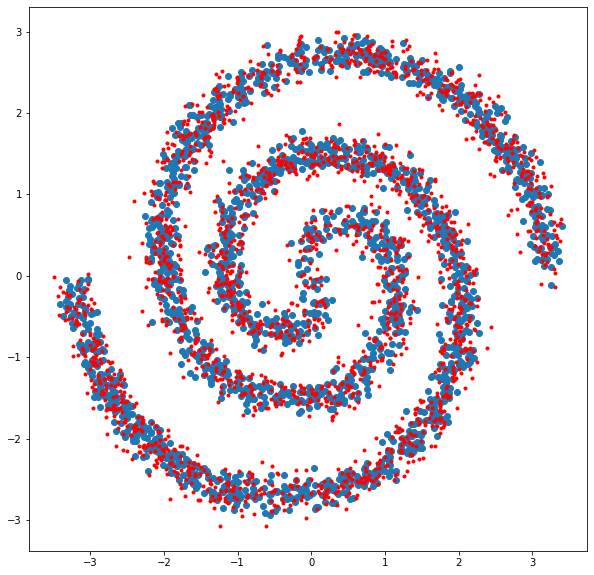

In [5]:
# Data generator implementation for 2D toy distributions: 8gaussians, 2spirals, checkerboard, rings

from tensorflow.keras.utils import Sequence
from utils import sample_2d_data
import numpy as np

class DataGenerator(Sequence):
    def __init__(self, sigma, num_total_samples=1e4, dataset='2spirals', batch_size=512):
        'Initialization'
        self.batch_size = batch_size
        self.num_total_samples = num_total_samples
        self.data = sample_2d_data(dataset, int(self.num_total_samples))
        self.sigma = sigma

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.num_total_samples // self.batch_size)

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            raise ValueError("idx must be an integer.")
        if not 0 <= idx < self.__len__():
            raise ValueError("idx is out of bounds.")

        # extract the current batch from dataset
        batch = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # generate a random noise batch
        batch_noise = np.random.normal(0, self.sigma, batch.shape)

        # add noise to the batch to generate noisy sampels
        batch_noisy = batch+batch_noise
        
        # output niosy and the ground truth noise (scaled by its variance, Eq. 5 in paper)
        return batch_noisy, -batch_noise/self.sigma/self.sigma

# This is a helper function to generate the denoised results from noisy input and noise estimates
def get_denoised(input_noisy, noise_estimate, sigma):
    return input_noisy+noise_estimate*sigma*sigma


# Visualise some samples
import matplotlib.pyplot as plt
generator = DataGenerator(sigma = 0.1, batch_size=2048)
batch_noisy, batch_noise = generator.__getitem__(0)
batch_gt = get_denoised(batch_noisy, batch_noise, generator.sigma)
plt.figure(figsize=(10,10))
plt.plot(batch_gt[:,0], batch_gt[:,1], 'o')
plt.plot(batch_noisy[:,0], batch_noisy[:,1], '.r')



In [6]:
# Helper functions and callbacks for visualization and writing of the resulting density

def get_density_map(wdt = 4, granularity = 10):
    x_range = np.array(range(-wdt*granularity, wdt*granularity))/granularity
    y_range = np.array(range(wdt*granularity, -wdt*granularity, -1))/granularity
    
    X, Y = np.meshgrid(x_range, y_range)
    shape = X.shape
    X = X.reshape(np.prod(shape), order='C')
    Y = Y.reshape(np.prod(shape), order='C')
    input_data = np.array([X,Y]).transpose()

    log_prob_data = dde(input_data)[0].numpy()
    log_prob_data -= log_prob_data.max()
    prob_data = np.exp(log_prob_data[:,0])
    prob_data = prob_data.reshape(shape, order='C')
    return prob_data
        
def get_vector_field(wdt = 4, granularity = 10):
    x_range = np.array(range(-wdt*granularity, wdt*granularity))/granularity
    y_range = np.array(range(wdt*granularity, -wdt*granularity, -1))/granularity
    
    X, Y = np.meshgrid(x_range, y_range)
    shape = X.shape
    X = X.reshape(np.prod(shape), order='C')
    Y = Y.reshape(np.prod(shape), order='C')
    input_data = np.array([X,Y]).transpose()

    logp, grads = dde(input_data)
    logp = logp.numpy()
    logp = logp[:,0].reshape(shape, order='C')
    grads = grads.numpy()
    d_X = grads[:,0].reshape(shape, order='C')
    d_Y = grads[:,1].reshape(shape, order='C')
    return x_range, y_range, d_X, d_Y, logp

def show_vectorfield_plot(x, y, d_x, d_y, logp):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    ax.streamplot(x, y, d_x, d_y, linewidth=1, color=logp, cmap=plt.cm.inferno,
          density=2, arrowstyle='->', arrowsize=1.5)
    ax.set_axis_off()

def show_density_plot(logp):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.imshow(np.exp(logp-logp.max()))
    ax.set_axis_off()

    
from tensorflow import keras
import matplotlib.pyplot as plt
class DensityPlotCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch%100 != 0:
            return
        
        logp = get_density_map()
        show_density_plot(logp)
        plt.show()
        
class DensityPlotWriterCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 10000 and epoch%1000 != 0:
            return
        if 300< epoch < 10000 and epoch%100 != 0:
            return
        epoch_id = str(epoch).zfill(6)
        
        plt.ion()
        x, y, d_x, d_y, logp = get_vector_field()        
        
        show_vectorfield_plot(x, y, d_x, d_y, logp)
        plt.savefig('vec_' + epoch_id)
        
        show_density_plot(logp)
        plt.savefig('den_' + epoch_id)
        plt.ioff()

Epoch 1/1000
1/4 [======>.......................] - ETA: 0s - loss: 105.1321WARNING:tensorflow:Layer dde is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



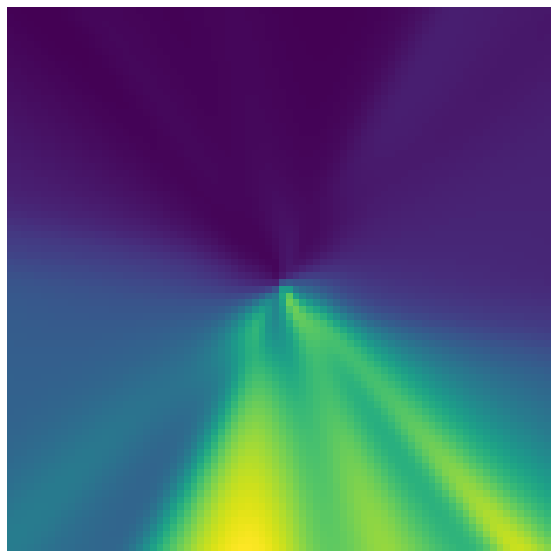

4/4 [==============================] - 0s 17ms/step - loss: 101.7992
Epoch 2/1000
4/4 [==============================] - 0s 1ms/step - loss: 100.5322
Epoch 3/1000
4/4 [==============================] - 0s 1ms/step - loss: 101.6082
Epoch 4/1000
4/4 [==============================] - 0s 1ms/step - loss: 98.9213
Epoch 5/1000
4/4 [==============================] - 0s 1ms/step - loss: 101.1405
Epoch 6/1000
4/4 [==============================] - 0s 1ms/step - loss: 100.4217
Epoch 7/1000
4/4 [==============================] - 0s 1ms/step - loss: 100.6915
Epoch 8/1000
4/4 [==============================] - 0s 1ms/step - loss: 102.7817
Epoch 9/1000
4/4 [==============================] - 0s 1ms/step - loss: 100.4813
Epoch 10/1000
4/4 [==============================] - 0s 1ms/step - loss: 96.9234
Epoch 11/1000
4/4 [==============================] - 0s 1ms/step - loss: 97.1476
Epoch 12/1000
4/4 [==============================] - 0s 1ms/step - loss: 98.1712
Epoch 13/1000
4/4 [======================

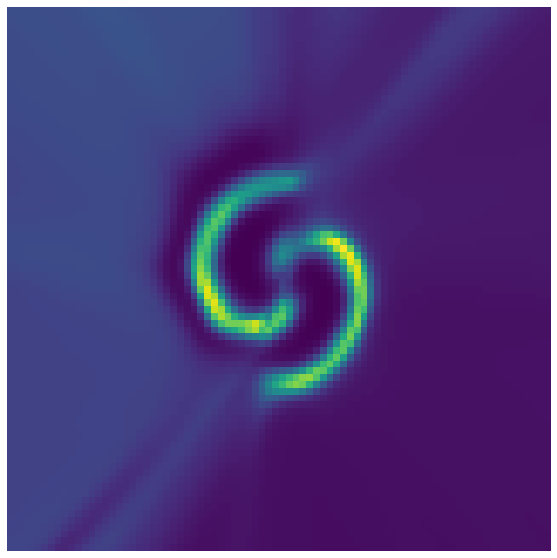

4/4 [==============================] - 0s 16ms/step - loss: 95.9882
Epoch 102/1000
4/4 [==============================] - 0s 1ms/step - loss: 95.3419
Epoch 103/1000
4/4 [==============================] - 0s 1ms/step - loss: 95.2058
Epoch 104/1000
4/4 [==============================] - 0s 1ms/step - loss: 93.9369
Epoch 105/1000
4/4 [==============================] - 0s 1ms/step - loss: 94.7790
Epoch 106/1000
4/4 [==============================] - 0s 1ms/step - loss: 94.1513
Epoch 107/1000
4/4 [==============================] - 0s 1ms/step - loss: 93.7968
Epoch 108/1000
4/4 [==============================] - 0s 1ms/step - loss: 95.5324
Epoch 109/1000
4/4 [==============================] - 0s 1ms/step - loss: 94.8113
Epoch 110/1000
4/4 [==============================] - 0s 1ms/step - loss: 94.5472
Epoch 111/1000
4/4 [==============================] - 0s 1ms/step - loss: 93.3980
Epoch 112/1000
4/4 [==============================] - 0s 1ms/step - loss: 92.4256
Epoch 113/1000
4/4 [==========

4/4 [==============================] - 0s 2ms/step - loss: 85.8192
Epoch 201/1000
1/4 [======>.......................] - ETA: 0s - loss: 89.1094

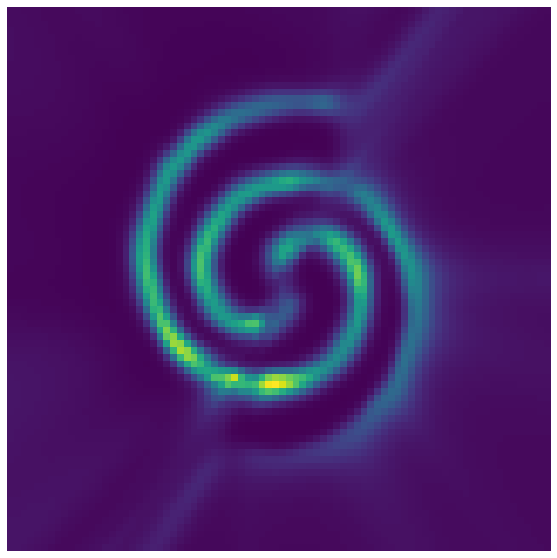

4/4 [==============================] - 0s 20ms/step - loss: 85.8865
Epoch 202/1000
4/4 [==============================] - 0s 1ms/step - loss: 85.8513
Epoch 203/1000
4/4 [==============================] - 0s 1ms/step - loss: 85.8990
Epoch 204/1000
4/4 [==============================] - 0s 1ms/step - loss: 84.8625
Epoch 205/1000
4/4 [==============================] - 0s 1ms/step - loss: 87.4967
Epoch 206/1000
4/4 [==============================] - 0s 1ms/step - loss: 88.2858
Epoch 207/1000
4/4 [==============================] - 0s 1ms/step - loss: 88.1557
Epoch 208/1000
4/4 [==============================] - 0s 1ms/step - loss: 85.6851
Epoch 209/1000
4/4 [==============================] - 0s 1ms/step - loss: 87.4064
Epoch 210/1000
4/4 [==============================] - 0s 1ms/step - loss: 88.4946
Epoch 211/1000
4/4 [==============================] - 0s 1ms/step - loss: 86.6500
Epoch 212/1000
4/4 [==============================] - 0s 1ms/step - loss: 87.2060
Epoch 213/1000
4/4 [==========

1/4 [======>.......................] - ETA: 0s - loss: 82.1824

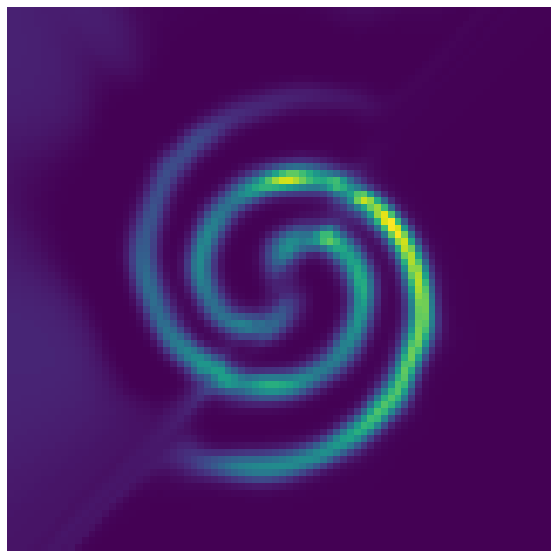

4/4 [==============================] - 0s 16ms/step - loss: 84.2824
Epoch 302/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.2103
Epoch 303/1000
4/4 [==============================] - 0s 1ms/step - loss: 83.5546
Epoch 304/1000
4/4 [==============================] - 0s 1ms/step - loss: 84.0869
Epoch 305/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.9314
Epoch 306/1000
4/4 [==============================] - 0s 1ms/step - loss: 83.1597
Epoch 307/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.0810
Epoch 308/1000
4/4 [==============================] - 0s 1ms/step - loss: 83.0819
Epoch 309/1000
4/4 [==============================] - 0s 1ms/step - loss: 84.3420
Epoch 310/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.4031
Epoch 311/1000
4/4 [==============================] - 0s 1ms/step - loss: 84.0362
Epoch 312/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.1803
Epoch 313/1000
4/4 [==========

4/4 [==============================] - 0s 2ms/step - loss: 84.4397
Epoch 401/1000
1/4 [======>.......................] - ETA: 0s - loss: 80.9285

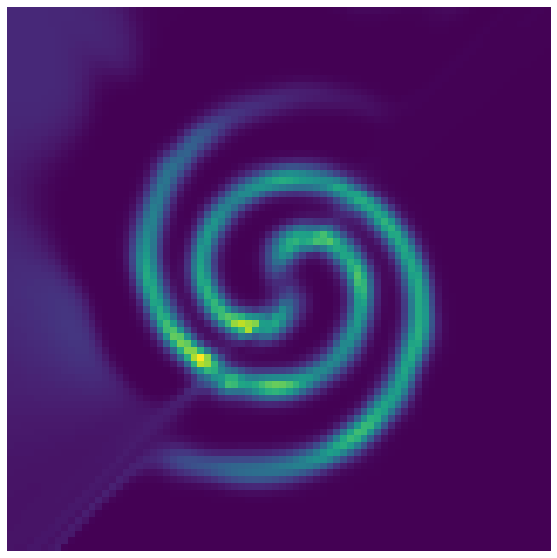

4/4 [==============================] - 0s 17ms/step - loss: 82.2781
Epoch 402/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.2449
Epoch 403/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.5759
Epoch 404/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.5704
Epoch 405/1000
4/4 [==============================] - 0s 1ms/step - loss: 83.5868
Epoch 406/1000
4/4 [==============================] - 0s 1ms/step - loss: 81.7819
Epoch 407/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.8120
Epoch 408/1000
4/4 [==============================] - 0s 1ms/step - loss: 81.9337
Epoch 409/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.6951
Epoch 410/1000
4/4 [==============================] - 0s 1ms/step - loss: 83.1404
Epoch 411/1000
4/4 [==============================] - 0s 1ms/step - loss: 83.1227
Epoch 412/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.4459
Epoch 413/1000
4/4 [==========

1/4 [======>.......................] - ETA: 0s - loss: 82.5025

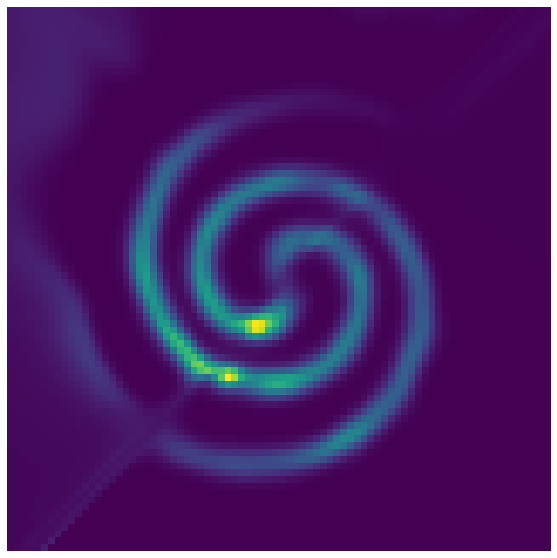

4/4 [==============================] - 0s 16ms/step - loss: 81.5683
Epoch 502/1000
4/4 [==============================] - 0s 1ms/step - loss: 81.5749
Epoch 503/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.7243
Epoch 504/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.3263
Epoch 505/1000
4/4 [==============================] - 0s 1ms/step - loss: 81.8327
Epoch 506/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.5094
Epoch 507/1000
4/4 [==============================] - 0s 1ms/step - loss: 83.3506
Epoch 508/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.1341
Epoch 509/1000
4/4 [==============================] - 0s 1ms/step - loss: 83.4416
Epoch 510/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.4101
Epoch 511/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.8664
Epoch 512/1000
4/4 [==============================] - 0s 2ms/step - loss: 82.3030
Epoch 513/1000
4/4 [==========

4/4 [==============================] - 0s 1ms/step - loss: 82.2548
Epoch 601/1000
1/4 [======>.......................] - ETA: 0s - loss: 79.0797

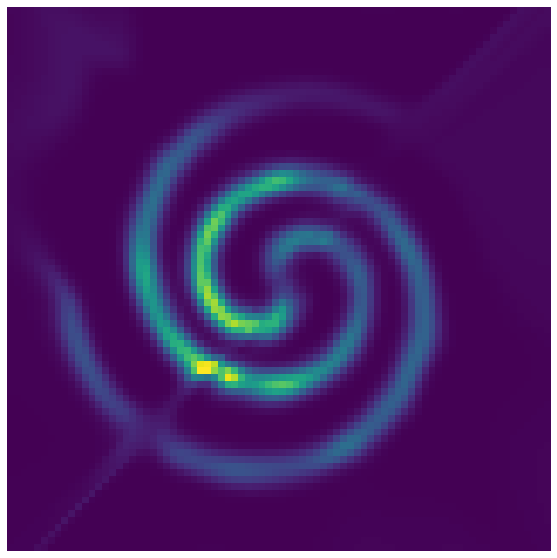

4/4 [==============================] - 0s 15ms/step - loss: 81.3666
Epoch 602/1000
4/4 [==============================] - 0s 1ms/step - loss: 81.0827
Epoch 603/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.8120
Epoch 604/1000
4/4 [==============================] - 0s 1ms/step - loss: 81.3250
Epoch 605/1000
4/4 [==============================] - 0s 1ms/step - loss: 81.2927
Epoch 606/1000
4/4 [==============================] - 0s 1ms/step - loss: 81.3432
Epoch 607/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.8367
Epoch 608/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.9226
Epoch 609/1000
4/4 [==============================] - 0s 1ms/step - loss: 81.2590
Epoch 610/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.3483
Epoch 611/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.3132
Epoch 612/1000
4/4 [==============================] - 0s 1ms/step - loss: 82.8947
Epoch 613/1000
4/4 [==========

1/4 [======>.......................] - ETA: 0s - loss: 77.0203

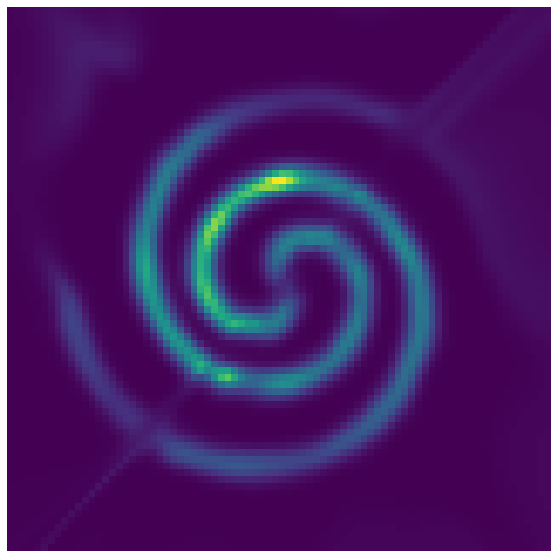

4/4 [==============================] - 0s 23ms/step - loss: 78.2262
Epoch 702/1000
4/4 [==============================] - 0s 1ms/step - loss: 77.7032
Epoch 703/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.4181
Epoch 704/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.5327
Epoch 705/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.7654
Epoch 706/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.8936
Epoch 707/1000
4/4 [==============================] - 0s 2ms/step - loss: 78.7624
Epoch 708/1000
4/4 [==============================] - 0s 2ms/step - loss: 79.0741
Epoch 709/1000
4/4 [==============================] - 0s 2ms/step - loss: 79.9467
Epoch 710/1000
4/4 [==============================] - 0s 2ms/step - loss: 79.3801
Epoch 711/1000
4/4 [==============================] - 0s 2ms/step - loss: 81.4282
Epoch 712/1000
4/4 [==============================] - 0s 2ms/step - loss: 78.9102
Epoch 713/1000
4/4 [==========

4/4 [==============================] - 0s 2ms/step - loss: 79.0200
Epoch 801/1000
1/4 [======>.......................] - ETA: 0s - loss: 79.9297

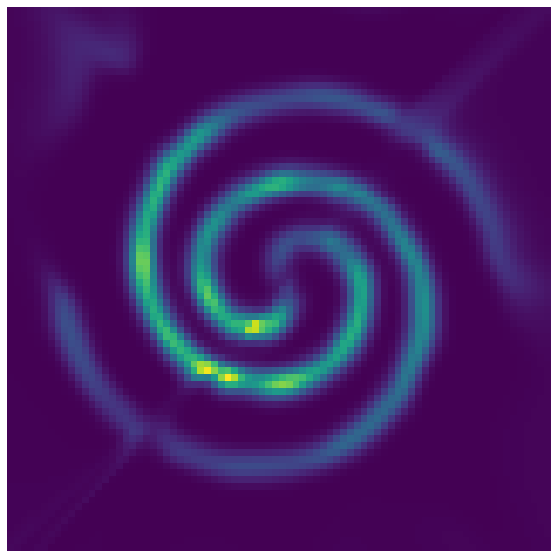

4/4 [==============================] - 0s 16ms/step - loss: 80.0626
Epoch 802/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.5347
Epoch 803/1000
4/4 [==============================] - 0s 1ms/step - loss: 78.7323
Epoch 804/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.0401
Epoch 805/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.3423
Epoch 806/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.3394
Epoch 807/1000
4/4 [==============================] - 0s 1ms/step - loss: 78.4517
Epoch 808/1000
4/4 [==============================] - 0s 1ms/step - loss: 77.7306
Epoch 809/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.1654
Epoch 810/1000
4/4 [==============================] - 0s 1ms/step - loss: 78.0624
Epoch 811/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.2273
Epoch 812/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.8508
Epoch 813/1000
4/4 [==========

1/4 [======>.......................] - ETA: 0s - loss: 82.5855

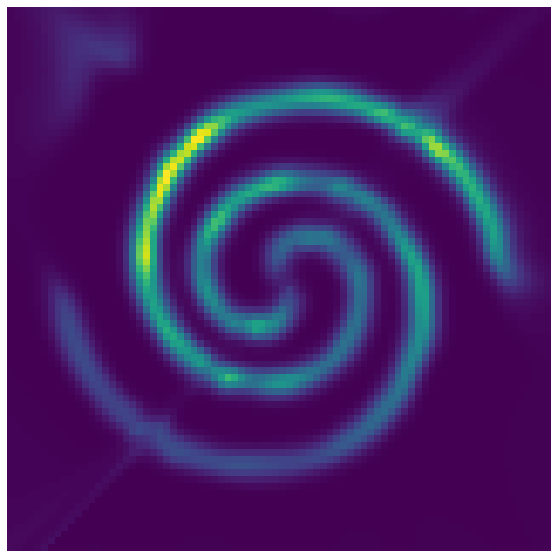

4/4 [==============================] - 0s 25ms/step - loss: 78.9488
Epoch 902/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.5547
Epoch 903/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.0783
Epoch 904/1000
4/4 [==============================] - 0s 2ms/step - loss: 79.1965
Epoch 905/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.9724
Epoch 906/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.8964
Epoch 907/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.0548
Epoch 908/1000
4/4 [==============================] - 0s 1ms/step - loss: 78.4958
Epoch 909/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.0350
Epoch 910/1000
4/4 [==============================] - 0s 1ms/step - loss: 77.9609
Epoch 911/1000
4/4 [==============================] - 0s 1ms/step - loss: 78.2581
Epoch 912/1000
4/4 [==============================] - 0s 1ms/step - loss: 80.2897
Epoch 913/1000
4/4 [==========

In [7]:
dde.fit(
    x=generator,
    epochs = 1000,
    callbacks=[DensityPlotCallback()])


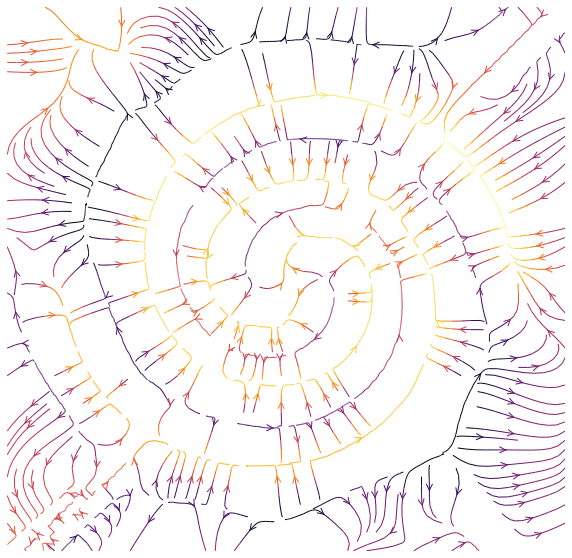

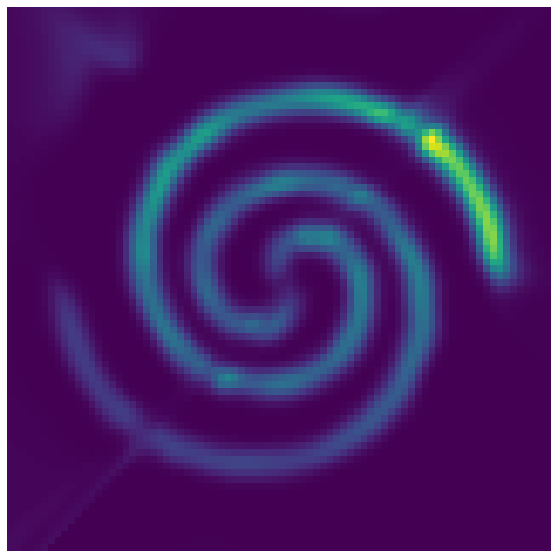

In [8]:
x, y, d_x, d_y, logp = get_vector_field()        

show_vectorfield_plot(x, y, d_x, d_y, logp)

show_density_plot(logp)